In [0]:
############## importing libraries ############## 
import numpy as np
import os
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt


4423680/4422102 [==============================] - 0s 0us/step


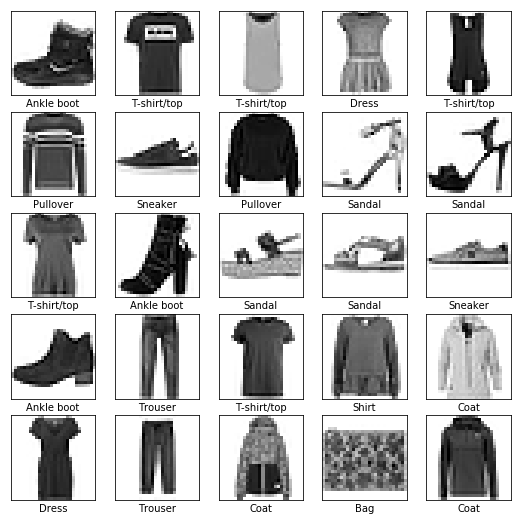

In [3]:
############################################ LOADING DATASET #####################################################
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
#getting data as train and test dataset
fmnist = tf.keras.datasets.fashion_mnist.load_data();
(train_images, train_labels), (test_images, test_labels) = fmnist
#defining categories for multiclassification
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#plotting one image of each category 
plt.figure(figsize=(9,9))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [5]:
############################################ PREPROCESS DATASET #####################################################
# image dimensions
n_inputs = 28*28   
# total of categories i.e 10 classes
n_outputs = 10 
# shuffle_batch() shuffle the examples in a batch before training
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# flattening the data
X_train_raw = train_images.reshape(len(train_images), n_inputs)
y_train = train_labels
X_test_raw = test_images.reshape(len(test_images), n_inputs)
y_test = test_labels


# use standard scaler for transforming data to have mean value 0 and std of 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# spilt training data into validation and training
X_train = X_train[5000:, :]
X_val = X_train[:5000, :]
y_train = y_train[5000:]
y_val = y_train[:5000]

# Print training set shape
print("x_train shape:", X_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(X_train.shape[0], 'train set')
print(X_val.shape[0], 'validation set')
print(X_test.shape[0], 'test set')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


x_train shape: (55000, 784) y_train shape: (55000,)
55000 train set
5000 validation set
10000 test set


## **Without Using any overfitting techniques**

In [0]:
#reset model
reset_graph() 
#defining hype parameters
learning_rate = 0.3
n_hidden1 = 512
n_hidden2 = 200

# Construct placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
############################################ BUILDING MODEL #####################################################
#building model layers
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name = "hidden1", 
                              activation = tf.nn.leaky_relu,
                             kernel_initializer = tf.contrib.layers.xavier_initializer(seed=42))
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name = "hidden2", 
                              activation = tf.nn.leaky_relu,
                             kernel_initializer = tf.contrib.layers.xavier_initializer(seed=42))
    logits = tf.layers.dense(hidden2, n_outputs, name = "outputs")
    
##################################### DEFINING LOSS, ACCURACY ####################################################
#defining loss function using crossentropy
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy, name = "loss")
#defining gradient optimizer and minimize loss
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
#defining accuracy formula
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

type(accuracy)

tensorflow.python.framework.ops.Tensor

In [0]:
############################################ TENSORFLOW SUMMARY  #####################################################
#defining variables foraccuracy and loss values for summary purpose
accuracy_value_ =tf.Variable(0.0) 
loss_value_ =tf.Variable(0.0)
#defining scalar summary for loss and accuracy
sumAcc=tf.summary.scalar('accuracy', accuracy_value_)
sumLoss=tf.summary.scalar('Loss', loss_value_)
#merge all the summary
write_op = tf.summary.merge_all()

In [0]:
#declaring global initializer
init = tf.global_variables_initializer()

# number of epochs 
n_epochs = 20
######################################### TRAINING, EVALUATING MODEL #####################################################
#begin the session 
with tf.Session() as sess:
    #initializing all the global variables
    init.run()
    #initializing summarywriter
    writer = tf.summary.FileWriter("/DNNTensorflow/train", sess.graph)
    writer1 = tf.summary.FileWriter("/DNNTensorflow/val", sess.graph)
    for epoch in range(n_epochs):
        sess.run(training_op, feed_dict={X: X_train, y: y_train})
        #calculating loss and accuracy for training and validation dataset
        loss_val = loss.eval(feed_dict={X: X_val, y: y_val})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        loss_train = loss.eval(feed_dict={X: X_train, y: y_train})
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
        
        #writing summary for training and vlaidation data
        _,_,summaryAccTrain = sess.run([sumAcc, sumLoss, write_op], feed_dict={accuracy_value_:acc_train,loss_value_:loss_train})
        writer.add_summary(summaryAccTrain, epoch)
        writer.flush()
        
        _,_,summaryAccVal = sess.run([sumAcc, sumLoss, write_op], feed_dict={accuracy_value_:acc_val,loss_value_:loss_val})
        #adding all the summary
        writer1.add_summary(summaryAccVal, epoch)
        writer1.flush()
        #printing loss and accuracy
        print(epoch, "Training Accuracy:", acc_train * 100, "\t loss: ", loss_train, "\t Validation Accuracy:", acc_val * 100, "validation Loss:", loss_val)
    
    #evaluating testing dataset and calculating loss and accuracy
    loss_test = loss.eval(feed_dict={X: X_test, y: y_test})
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Testing Accuracy:", acc_test *100, "\t loss: ", loss_test)
    

0 Training Accuracy: 62.07454800605774 	 loss:  1.6019244 	 Validation Accuracy: 60.75999736785889 validation Loss: 1.646568
1 Training Accuracy: 52.189093828201294 	 loss:  3.147479 	 Validation Accuracy: 52.799999713897705 validation Loss: 3.1087768
2 Training Accuracy: 44.74727213382721 	 loss:  2.7234693 	 Validation Accuracy: 43.50000023841858 validation Loss: 2.826879
3 Training Accuracy: 49.55272674560547 	 loss:  1.4314582 	 Validation Accuracy: 48.980000615119934 validation Loss: 1.4582039
4 Training Accuracy: 64.60545659065247 	 loss:  1.0318496 	 Validation Accuracy: 63.840001821517944 validation Loss: 1.0601642
5 Training Accuracy: 74.60363507270813 	 loss:  0.7275613 	 Validation Accuracy: 73.86000156402588 validation Loss: 0.7452688
6 Training Accuracy: 76.16363763809204 	 loss:  0.6788912 	 Validation Accuracy: 75.70000290870667 validation Loss: 0.6981022
7 Training Accuracy: 77.14181542396545 	 loss:  0.6494332 	 Validation Accuracy: 76.71999931335449 validation Loss: 0

## **Preventing Overfitting** 

In [0]:
####################################### DEFINING HYPERPARAMETERS ###############################################
# reset model
reset_graph() 
#defining hyper parameters
learning_rate = 0.3
n_hidden1 = 512
n_hidden2 = 200

# Defining placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape = (), name = 'training')
#will be used for dropout layers
keepProb = tf.placeholder(tf.float32)

####################################### BUILDING IMPROVED MODEL ###############################################
# building dense neural network model
with tf.name_scope("dnn"):
    flatten1=tf.keras.layers.Flatten()
    hidden1 = tf.layers.dense(X, n_hidden1, name = "hidden1",activation=tf.nn.leaky_relu,
                             kernel_initializer = tf.contrib.layers.xavier_initializer(seed=42)) #initializing weights using Xavier and Yoshua's method
    #adding dropout layer: keep_prob-percentage of how much neurons to keep for forward pass
    dropout0 = tf.contrib.layers.dropout(hidden1, keep_prob =keepProb)
    # second layer
    hidden2 = tf.layers.dense(dropout0, n_hidden2, name = "hidden2",activation=tf.nn.leaky_relu,
                             kernel_initializer = tf.contrib.layers.xavier_initializer(seed=42))
    dropout2 = tf.contrib.layers.dropout(hidden2, keep_prob=keepProb)
    #output layer having category 10 classes
    logits = tf.layers.dense(dropout2, n_outputs, name = "outputs")

####################################### DEFINING LOSS, ACCURACY ###############################################
#defining loss
with tf.name_scope("loss"):
  # using softmax cross entropy for multiclass output
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name = "loss")

with tf.name_scope("train"):
    # using adagradOptimizer for optimizing
    optimizer = tf.train.AdagradOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

 #defining accuracy 
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [0]:
############################################ TENSORFLOW SUMMARY #####################################################
#variables for loss and accuracy used for summary 
accuracy_value_ =tf.Variable(0.0) 
loss_value_ =tf.Variable(0.0)
#declaring scalar summary
sumAcc=tf.summary.scalar('accuracy', accuracy_value_)
sumLoss=tf.summary.scalar('Loss', loss_value_)
#merge all the summary
write_op = tf.summary.merge_all()

In [0]:
#declaring global initializer
init = tf.global_variables_initializer()
#to save the model
saver = tf.train.Saver()
# number of epochs and batch sizes
n_epochs = 20
batch_size = 16

########################################## TRAINING, EVALUATING MODEL #####################################################
#running the session
with tf.Session() as sess:
    #initialzing all the global variables
    init.run()
    #declaring two writers for training and validation dataset
    writer = tf.summary.FileWriter("/DNNTensorflow/train", sess.graph)
    writer1 = tf.summary.FileWriter("/DNNTensorflow/val", sess.graph)
    for epoch in range(n_epochs):
        #creating batches for training and validation dataset using shuffle 
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            #using keepProb to keep 70%of nodesin dropout layer
            sess.run([training_op],feed_dict={training: True, X: X_batch, y: y_batch,keepProb:0.7})
        
        #evaluating accuracy and loss for validation and training dataset
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val,keepProb:1.0})
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train,keepProb:0.7})
        loss_train=loss.eval(feed_dict={X: X_train, y: y_train,keepProb:0.7})
        loss_val=loss.eval(feed_dict={X: X_val, y: y_val,keepProb:1.0})
        #running summary object to add accuracy , loss to the summary writer object
        _,_,summaryAccTrain = sess.run([sumAcc, sumLoss, write_op], feed_dict={accuracy_value_:acc_train,loss_value_:loss_train})
        writer.add_summary(summaryAccTrain, epoch)
        writer.flush()
        
        _,_,summaryAccVal = sess.run([sumAcc, sumLoss, write_op], feed_dict={accuracy_value_:acc_val,loss_value_:loss_val})
        writer1.add_summary(summaryAccVal, epoch)
        writer1.flush()
        
        print(epoch, "Training Accuracy:", acc_train*100,"\tLoss: " ,loss_train, "\tValidation Accuracy:", acc_val*100,"\t Validation Loss: " ,loss_val)
    
    ############################################ SAVING MODEL #####################################################
    #save the model
    save_path = saver.save(sess, "./content/model.ckpt")
    #evaluating the accuracy on testing dataset
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test,keepProb:1.0})
    loss_test=loss.eval(feed_dict={X: X_test, y: y_test,keepProb:1.0})
    print("Test Accuracy:", acc_test*100,"\tLoss: " , loss_test)

0 Training Accuracy: 78.49090695381165 	Loss:  17.83435 	Validation Accuracy: 82.9200029373169 	 Validation Loss:  11.187005
1 Training Accuracy: 77.88545489311218 	Loss:  11.121552 	Validation Accuracy: 81.36000037193298 	 Validation Loss:  6.964653
2 Training Accuracy: 79.49272990226746 	Loss:  5.626033 	Validation Accuracy: 83.96000266075134 	 Validation Loss:  2.6711867
3 Training Accuracy: 80.11454343795776 	Loss:  4.057061 	Validation Accuracy: 84.34000015258789 	 Validation Loss:  2.4112728
4 Training Accuracy: 80.13272881507874 	Loss:  3.5360591 	Validation Accuracy: 84.38000082969666 	 Validation Loss:  1.9590462
5 Training Accuracy: 80.94909191131592 	Loss:  2.897683 	Validation Accuracy: 84.35999751091003 	 Validation Loss:  1.6844838
6 Training Accuracy: 81.35272860527039 	Loss:  2.582857 	Validation Accuracy: 85.79999804496765 	 Validation Loss:  1.3825206
7 Training Accuracy: 82.2527289390564 	Loss:  2.2906146 	Validation Accuracy: 85.61999797821045 	 Validation Loss:  1.